In [1]:
from langchain.schema import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_groq import ChatGroq
from typing import Annotated, Literal, TypedDict, List
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from dotenv import load_dotenv
from pydantic import BaseModel, Field
load_dotenv()

True

In [2]:
### Creating some documents ##
docs = [
    Document(
        page_content="The Board of Control for Cricket in India (BCCI) is the governing body for cricket in India. It was formed in December 1928.",
        metadata={"source": "bcci.txt"}
    ),
    Document(
        page_content="Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.",
        metadata={"source": "virat_kohli.txt"}
    ),
    Document(
        page_content="India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.",
        metadata={"source": "world_cups.txt"}
    ),
    Document(
        page_content="The Indian Premier League (IPL) is a T20 cricket league established in 2008. It features franchises like Mumbai Indians, Chennai Super Kings, and Royal Challengers Bangalore.",
        metadata={"source": "ipl.txt"}
    ),
    Document(
        page_content="Sachin Tendulkar is widely regarded as one of the greatest cricketers in history. He scored 100 international centuries and played for India for over two decades.",
        metadata={"source": "sachin_tendulkar.txt"}
    ),
    Document(
        page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.",
        metadata={"source": "bowlers.txt"}
    )
]

In [3]:
##creating the vector database
import os
persistent_dir = os.path.join("db","chroma_db")
embedding_func = HuggingFaceEmbeddings(model_name = 'sentence-transformers/all-mpnet-base-v2') ##Huggingface embeddings
vec_db = Chroma.from_documents(docs, embedding_func,persist_directory=persistent_dir) ##creating the vector db with Chroma

In [4]:
## creating the retriever ##
retriever = vec_db.as_retriever(search_type='mmr',search_kwargs={'k':3})
retriever.invoke("Who captained India in 1983 World Cup?")

Number of requested results 20 is greater than number of elements in index 18, updating n_results = 18


[Document(metadata={'source': 'world_cups.txt'}, page_content='India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.'),
 Document(metadata={'source': 'virat_kohli.txt'}, page_content='Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.'),
 Document(metadata={'source': 'bowlers.txt'}, page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.")]

In [5]:
from langchain_core.prompts import ChatPromptTemplate
template = '''
Here is the context : {context}, based on this answer the following question
Question : {question}
'''
prompt = ChatPromptTemplate.from_template(template)
llm_model = ChatGroq(model = 'llama-3.1-8b-instant')
rag_chain = prompt | llm_model

In [33]:
## state creation, keeps a track of messages, documents, or whether the topic can be answered or not?
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str

In [34]:
##pydantic class to ground the model output
class GradeQuestion(BaseModel):
    """Answers Yes or No to whether the topic is related to Cricket in India or not"""
    score: str = Field(description="Question is about cricket? if yes -> 'Yes' if not -> 'No'")

### common way to test this ###
## test = GradeQuestion(**{'score':'Indian Cricket'})

In [35]:
def question_classifier(state:AgentState):
    print("State:",state)
    question = state["messages"][-1].content
    system = """You are a classifier that determines whether the user's question is about cricket in India or not
    If the question is in line with cricker in India, respond with 'Yes'. Otherwise, respond with 'No'.
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [('system',system),
        ('human',"User Question: {question}")
        ])

    structured_llm = llm_model.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({'question':question})

    state['on_topic'] = result.score
    return state

In [36]:
## testing the question classifier ###
question_classifier({"messages":[HumanMessage(content="India won in 2011 under whom?")],
                    "documents":[Document(metadata={'source': 'world_cups.txt'}, page_content='India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.'),
                                 Document(metadata={'source': 'virat_kohli.txt'}, page_content='Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.'),
                                 Document(metadata={'source': 'bowlers.txt'}, page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.")],
                    "on_topic":""})

State: {'messages': [HumanMessage(content='India won in 2011 under whom?', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'source': 'world_cups.txt'}, page_content='India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.'), Document(metadata={'source': 'virat_kohli.txt'}, page_content='Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.'), Document(metadata={'source': 'bowlers.txt'}, page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.")], 'on_topic': ''}


{'messages': [HumanMessage(content='India won in 2011 under whom?', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'world_cups.txt'}, page_content='India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.'),
  Document(metadata={'source': 'virat_kohli.txt'}, page_content='Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.'),
  Document(metadata={'source': 'bowlers.txt'}, page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.")],
 'on_topic': 'Yes'}

In [80]:
## testing the question classifier ###
question_classifier({"messages":[HumanMessage(content="Greatest batsman from Australia")],
                    "documents":[Document(metadata={'source': 'world_cups.txt'}, page_content='India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.'),
                                 Document(metadata={'source': 'virat_kohli.txt'}, page_content='Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.'),
                                 Document(metadata={'source': 'bowlers.txt'}, page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.")],
                    "on_topic":""})

{'messages': [HumanMessage(content='Greatest batsman from Australia', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'world_cups.txt'}, page_content='India won its first Cricket World Cup in 1983 under the captaincy of Kapil Dev. They won again in 2011, led by Mahendra Singh Dhoni.'),
  Document(metadata={'source': 'virat_kohli.txt'}, page_content='Virat Kohli, one of the leading batsmen in the world, made his debut for India in 2008. He has captained the team across formats and holds several batting records.'),
  Document(metadata={'source': 'bowlers.txt'}, page_content="India's current top bowlers include Jasprit Bumrah and Ravichandran Ashwin. Bumrah is known for his death-over precision, while Ashwin is a top-performing off-spinner.")],
 'on_topic': 'No'}

In [37]:
def on_topic_router(state:AgentState):
    ##based on the on topic response by grader route the agent##
    on_topic = state['on_topic']
    if on_topic.lower() == 'yes':
        return "on_topic"
    else:
        return "off_topic"

def retrieve_docs(state:AgentState):
    ### retrieval system by the agent ###
    question = state['messages'][-1].content
    documents = retriever.invoke(question)
    state['documents'] = documents
    return state

def generate_answer(state:AgentState):
    question = state['messages'][-1].content
    documents = state['documents']
    generated = rag_chain.invoke({'context':documents,'question':question})
    state["messages"].append(generated)

def off_topic(state:AgentState):
    state["messages"].append(AIMessage(content="I do not have a answer for this"))
    return state

In [38]:
## creating the workflow###
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)
workflow.add_node('question_classifier',question_classifier)
workflow.add_node('off_topic',off_topic)
workflow.add_node('retrieve',retrieve_docs)
workflow.add_node('generate_answer',generate_answer)

workflow.add_conditional_edges("question_classifier",on_topic_router,
                               {
                                  "on_topic":"retrieve",
                                  "off_topic":"off_topic"
                              }) ##flow --> question classifier present node, on_topic_router function uses the state to decide
                                 ##{} the dict shows the branching

workflow.add_edge("retrieve","generate_answer")
workflow.add_edge("generate_answer",END)
workflow.add_edge("off_topic",END)
workflow.set_entry_point("question_classifier")
graph = workflow.compile()

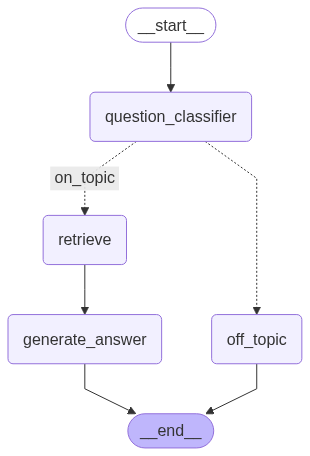

In [39]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [41]:
result = graph.invoke(input={
    "messages":[HumanMessage(content='Name the two captains who won the World Cup for India?')],
    "documents":[],
    "on_topic":''
})

State: {'messages': [HumanMessage(content='Name the two captains who won the World Cup for India?', additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': ''}


Number of requested results 20 is greater than number of elements in index 18, updating n_results = 18


In [45]:
result['messages'][-1].content

'Based on the provided context, the two captains who won the World Cup for India are:\n\n1. Kapil Dev (1983)\n2. Mahendra Singh Dhoni (2011)'